# Project 3 -- predicting cloud cover 

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import train_test_split

#%matplotlib notebook

In [2]:
def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log(x/(1-x))

# Reading in the data

In [3]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

#print(cloud.variables)
tcc = cloud.variables["tcc"][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][0].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][0].data

surf_pre = pressure.variables["sp"][:].data
temp = temperature.variables["t2m"][:].data

In [24]:
# for one certain timestep 
t = 1

y = tcc[t].flatten().reshape((4697, 1)) #logit(tcc[0].flatten()).reshape((4697, 1))
X = np.array([rel[t].flatten(), spe[t].flatten(), surf_pre[t].flatten(), temp[t].flatten()]).transpose()
                    
                    
# Testing is a different timestep??
# Training for several timesteps

In [7]:
y.shape

(4697, 1)

In [8]:
X.shape

(4697, 4)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)


# Regression analysis 

In [9]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
6


In [10]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [11]:
results["r2_test"]["ridge"]

[[0.29468026285069693,
  0.29456526115911474,
  0.2931930834869302,
  0.29071339372042415,
  0.29011291548567775,
  0.2900445095421528,
  0.29003327612241336,
  0.2899887080930573,
  0.2895108088117425,
  0.2819090173572594]]

In [12]:
results["r2_test"]["ols"]

[[0.26069385926072863]]

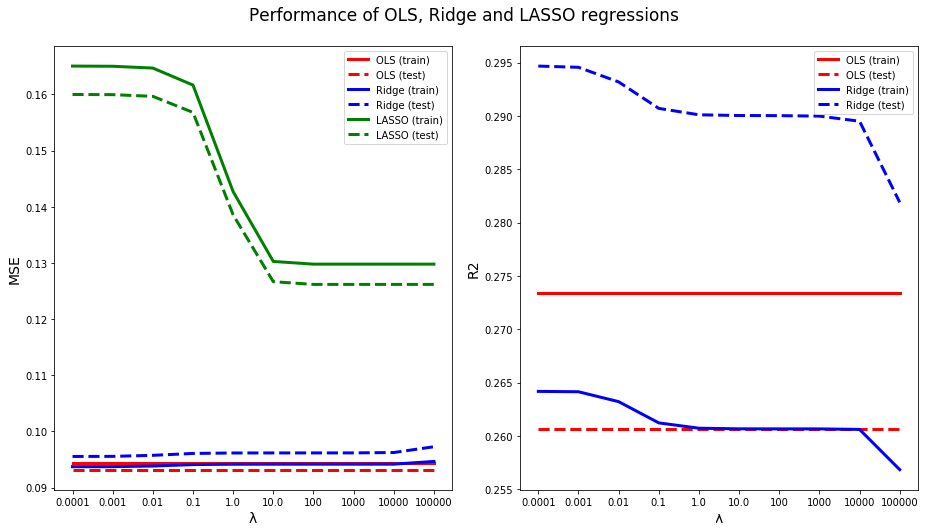

In [13]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
#plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
#plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [16]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [17]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [18]:
bias

{'ridge': 0.09398233371398797,
 'lasso': 0.09482311832154165,
 'ols': 0.09397958714848735}

In [19]:
var # variance dominates because we don't have so mush data???

{'ridge': 0.00010438231317453392,
 'lasso': 0.00011613131137079264,
 'ols': 0.0001090472538421933}

In [20]:
mse_test

{'ridge': 0.0940867160271625,
 'lasso': 0.09493924963291243,
 'ols': 0.09408863440232954}

In [21]:
bias["ols"] + var["ols"] 

0.09408863440232955

In [22]:
bias["ridge"] + var["ridge"] 

0.0940867160271625

In [23]:
bias["lasso"] + var["lasso"] 

0.09493924963291245

The bias and variance summes to the mse of the ols model.